# Brain Tumor Detection
## Resnet101 - Classifier + Regressor
Description
This dataset was originally created by Yousef Ghanem. To see the current project, which may have been updated since this version, please go here: https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f.

This dataset is part of RF100, an Intel-sponsored initiative to create a new object detection benchmark for model generalizability.

Access the RF100 Github repo: https://github.com/roboflow-ai/roboflow-100-benchmark

## Imports

In [1]:
# Go to project root folder
import os
os.chdir("../")
%pwd

'/workspaces/brain-tumor-detection'

In [2]:
import numpy as np
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()

import tensorflow as tf
tf.random.set_seed(42)

import matplotlib.pyplot as plt

2025-03-15 14:30:35.792111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742049035.800676  325487 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742049035.803220  325487 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742049035.812890  325487 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742049035.812906  325487 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742049035.812908  325487 computation_placer.cc:177] computation placer alr

In [3]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.19.0')

In [4]:
from src.data_handler.data_loader import DataLoader
from src.data_handler.annotation_processor import AnnotationProcessor
from src.data_handler.preprocessor import Preprocessor

In [5]:
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths Setup

In [6]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/-Brain-Tumor-Detection-2/train/


In [7]:
cfg.DATASET_DIRS

{'TRAIN_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/train/', 'VALIDATION_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/valid', 'TEST_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/test'}

In [8]:
DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)


IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE
LOG_DIR = cfg.OUTPUTS.LOG_DIR
CHECK_POINT_DIR = Path(cfg.OUTPUTS.CHECKPOINT_PATH)
CLASS_NAME = [
    'label0',
    'label1',
    'label2'
]
class_map = {k: v for k, v in enumerate(CLASS_NAME)}

NUM_EPOCHS = cfg.TRAIN.NUM_EPOCHS
LEARNING_RATE = cfg.TRAIN.LEARNING_RATE

NUM_CLASSES = len(CLASS_NAME)

## Dataset Download from Roboflow

In [9]:
if not TRAIN_DIR.exists():
    from roboflow import Roboflow
    rf = Roboflow(api_key="AAjLIN3PenSZ29LjbI3d")
    project = rf.workspace("yousef-ghanem-jzj4y").project("brain-tumor-detection-fpf1f")
    version = project.version(2)
    dataset = version.download("tensorflow") 

## Load images from directory

In [10]:
prepare_train_dataset = AnnotationProcessor(annotation_file= str(TRAIN_DIR/'_annotations.csv'))
_class_map = {v: k for k, v in enumerate(CLASS_NAME)}
train_images, train_class_ids, train_bboxes  = prepare_train_dataset.process_annotations(image_dir=TRAIN_DIR, class_id_map=_class_map)

len(train_images), len(train_class_ids), len(train_bboxes)

(6851, 6851, 6851)

In [11]:
train_bboxes[0]

array([[0.68345324, 0.54545455, 0.95683453, 0.76515152],
       [0.42446043, 0.48484848, 0.99280576, 0.96969697],
       [0.46043165, 0.53030303, 0.99280576, 0.78030303]])

In [12]:
train_class_ids

[[0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1],
 [0, 1, 2],
 [0, 1, 2],
 [1, 2],
 [0, 1],
 [1],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [1, 2],
 [0, 1],
 [2],
 [1],
 [0, 1, 2],
 [1],
 [1],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1],
 [1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1],
 [0, 1, 2],
 [1],
 [0, 1],
 [0, 1, 2],
 [1],
 [1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [1],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2]

In [13]:
train_dl = DataLoader(train_images, train_class_ids, train_bboxes)
train_ds = train_dl.load_train_dataset()
train_ds = Preprocessor(train_ds).preprocess()
train_ds = train_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

I0000 00:00:1742049049.326821  325487 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7212 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [14]:
for batch in train_ds.take(1):
    image, (cls, bbx) = batch
    print(image.shape, cls.shape, bbx.shape)
    print(cls[5])
    print(image[1].numpy().min(), image[1].numpy().max())
    for c in cls:
        print(c.numpy())

(32, 240, 240, 3) (32, 3) (32, 3, 4)
tf.Tensor([1. 1. 1.], shape=(3,), dtype=float32)
-112.33852 151.061
[0. 1. 0.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 0.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 0.]
[0. 1. 0.]
[1. 1. 1.]
[0. 1. 0.]
[0. 1. 0.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 0.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[0. 1. 0.]


2025-03-15 14:30:55.037625: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Validation datasets setup

In [15]:
prepare_valid_dataset = AnnotationProcessor(annotation_file= str(VALIDATION_DIR/'_annotations.csv'))

valid_image_paths, valid_class_ids, valid_bboxes  = prepare_valid_dataset.process_annotations(image_dir=VALIDATION_DIR, class_id_map=_class_map)
len(valid_image_paths), len(valid_class_ids), len(valid_bboxes)

(1963, 1963, 1963)

In [16]:
valid_dl = DataLoader(valid_image_paths, valid_class_ids, valid_bboxes).load_val_dataset()
valid_ds = Preprocessor(valid_dl).preprocess()
valid_ds = valid_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

In [17]:
for batch in valid_ds.take(1):
    image, (cls, bbx) = batch
    print(image.shape, cls.shape, bbx.shape)
    print(image[1].numpy().min(), image[1].numpy().max())

(32, 240, 240, 3) (32, 3) (32, 3, 4)
-123.68 138.49847


2025-03-15 14:30:57.530535: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training Setup

## Define loss

In [18]:
padded_class_ids = train_dl.multi_hot_class_ids
padded_class_ids[:10]

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [0., 1., 0.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 0.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

In [19]:
from src.losses import binary_weighted_loss as _loss

positive_weights, negative_weights = _loss.compute_class_weights(padded_class_ids)
positive_weights, negative_weights 

(array([0.38140417, 0.01547219, 0.40767771]),
 array([0.61859584, 0.9845278 , 0.5923223 ], dtype=float32))

## Define ResNet50 Model

### Final Model

In [34]:
from src.losses import iou_loss
CLS_METRICS = [
    tf.keras.metrics.AUC(name='AUC', multi_label=True), 
    tf.keras.metrics.F1Score(name='f1_score',average='weighted')]


REG_METRICS = [
    iou_loss.iou_metric,
    tf.keras.metrics.MeanSquaredError(name='mse'),
    tf.keras.metrics.MeanAbsoluteError(name='mae'),]

### Define  Callbacks

In [35]:
import os
import mlflow
# to_monitor = 'val_classification_AUC'
# mode = 'max'
to_monitor = 'val_bounding_box_iou_metric'
mode = 'max'
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, 
                                            patience=5, 
                                            monitor=to_monitor,
                                            mode=mode,
                                            min_lr=1e-7,
                                            verbose=1),

    tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(str(CHECK_POINT_DIR), "detector_ckpt_{epoch}.keras") ,
                                        save_weights_only=False,
                                        save_best_only=True,
                                        monitor=to_monitor,
                                        mode=mode,
                                        verbose=1),
                                        
    tf.keras.callbacks.EarlyStopping(monitor=to_monitor, 
                                    patience=10,
                                    mode=mode, 
                                    restore_best_weights=True,
                                    verbose=1),

]

mlflow.set_experiment("/brain-tumor-resnet101-detector")
mlflow.tensorflow.autolog(log_models=True, 
                          log_datasets=False, 
                          log_input_examples=True,
                          keras_model_kwargs={"save_format": "keras"},
                          checkpoint_monitor=to_monitor, 
                          checkpoint_mode=mode)

2025/03/15 14:38:13 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.18.0, but the installed version is 2.19.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.


### Define Optimizer

In [36]:
optimizer=tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE)

## Model Building and Compilation

In [37]:
from src.models.resnet101 import final_model
tf.keras.backend.clear_session()

model = final_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES)

model.compile(
    optimizer=optimizer,
    loss={'classification': _loss.set_binary_crossentropy_weighted_loss(positive_weights, negative_weights),
          'bounding_box': iou_loss.iou_loss},
    metrics={'classification': CLS_METRICS, 'bounding_box': REG_METRICS})  # Use IoU metric
model.summary()

Total layers in ResNet101: 345
Unfreezing the last 172 layers (50% of total layers)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 246, 246,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 120, 120,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 120, 120,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 120, 120,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 122, 122,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 60, 60,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 60, 60,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 60, 60,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 60, 60,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 60, 60,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 60, 60,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 60, 60,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 60, 60,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 60, 60,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 60, 60,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 60, 60,    │      1,024 │ conv2_block1_3_c

 Total params: 45,288,847 (172.76 MB)

 Trainable params: 33,268,751 (126.91 MB)

 Non-trainable params: 12,020,096 (45.85 MB)

### Train and Validate the model

In [38]:
history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=valid_ds,
    batch_size=BATCH_SIZE,
    callbacks=[callbacks],
)

2025/03/15 14:38:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c7b47fe8fb4047f093d4cb1bced7a94a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - bounding_box_iou_metric: 0.0928 - bounding_box_loss: 0.9075 - bounding_box_mae: 0.2972 - bounding_box_mse: 0.1350 - classification_AUC: 0.6684 - classification_f1_score: 0.5421 - classification_loss: 0.6219 - loss: 7.4901
Epoch 1: val_bounding_box_iou_metric improved from -inf to 0.20812, saving model to output/checkpoints/detector_ckpt_1.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 92s 239ms/step - bounding_box_iou_metric: 0.0930 - bounding_box_loss: 0.9073 - bounding_box_mae: 0.2972 - bounding_box_mse: 0.1350 - classification_AUC: 0.6688 - classification_f1_score: 0.5421 - classification_loss: 0.6216 - loss: 7.4858 - val_bounding_box_iou_metric: 0.2081 - val_bounding_box_loss: 0.7924 - val_bounding_box_mae: 0.2529 - val_bounding_box_mse: 0.1139 - val_classification_AUC: 0.8381 - val_classification_f1_score: 0.5588 - val_classification_loss: 0.5859 - val_loss: 5.0207 - learning_rate: 1.0000e-04
Epoch 2/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - bounding_box_iou_metric: 0.2393 - bounding_box_loss: 0.7615 - bounding_box_mae: 0.2385 - bounding_box_mse: 0.1082 - classification_AUC: 0.8553 - classification_f1_score: 0.5850 - classification_loss: 0.4218 - loss: 4.3307
Epoch 2: val_bounding_box_iou_metric improved from 0.20812 to 0.32950, saving model to output/checkpoints/detector_ckpt_2.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 36s 147ms/step - bounding_box_iou_metric: 0.2396 - bounding_box_loss: 0.7612 - bounding_box_mae: 0.2384 - bounding_box_mse: 0.1081 - classification_AUC: 0.8554 - classification_f1_score: 0.5849 - classification_loss: 0.4217 - loss: 4.3265 - val_bounding_box_iou_metric: 0.3295 - val_bounding_box_loss: 0.6717 - val_bounding_box_mae: 0.2019 - val_bounding_box_mse: 0.0889 - val_classification_AUC: 0.8820 - val_classification_f1_score: 0.5838 - val_classification_loss: 0.5452 - val_loss: 3.2104 - learning_rate: 1.0000e-04
Epoch 3/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - bounding_box_iou_metric: 0.3212 - bounding_box_loss: 0.6794 - bounding_box_mae: 0.2171 - bounding_box_mse: 0.1030 - classification_AUC: 0.9063 - classification_f1_score: 0.5967 - classification_loss: 0.3272 - loss: 2.7608
Epoch 3: val_bounding_box_iou_metric improved from 0.32950 to 0.35516, saving model to output/checkpoints/detector_ckpt_3.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 36s 147ms/step - bounding_box_iou_metric: 0.3213 - bounding_box_loss: 0.6793 - bounding_box_mae: 0.2171 - bounding_box_mse: 0.1030 - classification_AUC: 0.9064 - classification_f1_score: 0.5967 - classification_loss: 0.3273 - loss: 2.7589 - val_bounding_box_iou_metric: 0.3552 - val_bounding_box_loss: 0.6459 - val_bounding_box_mae: 0.1908 - val_bounding_box_mse: 0.0809 - val_classification_AUC: 0.8744 - val_classification_f1_score: 0.5813 - val_classification_loss: 0.4601 - val_loss: 2.2935 - learning_rate: 1.0000e-04
Epoch 4/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - bounding_box_iou_metric: 0.3553 - bounding_box_loss: 0.6450 - bounding_box_mae: 0.2145 - bounding_box_mse: 0.1058 - classification_AUC: 0.9373 - classification_f1_score: 0.6075 - classification_loss: 0.2726 - loss: 1.9838
Epoch 4: val_bounding_box_iou_metric improved from 0.35516 to 0.39440, saving model to output/checkpoints/detector_ckpt_4.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 36s 147ms/step - bounding_box_iou_metric: 0.3554 - bounding_box_loss: 0.6449 - bounding_box_mae: 0.2145 - bounding_box_mse: 0.1057 - classification_AUC: 0.9373 - classification_f1_score: 0.6075 - classification_loss: 0.2726 - loss: 1.9827 - val_bounding_box_iou_metric: 0.3944 - val_bounding_box_loss: 0.6068 - val_bounding_box_mae: 0.1946 - val_bounding_box_mse: 0.0922 - val_classification_AUC: 0.9003 - val_classification_f1_score: 0.5705 - val_classification_loss: 0.4105 - val_loss: 1.7895 - learning_rate: 1.0000e-04
Epoch 5/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - bounding_box_iou_metric: 0.3843 - bounding_box_loss: 0.6168 - bounding_box_mae: 0.2071 - bounding_box_mse: 0.1041 - classification_AUC: 0.9593 - classification_f1_score: 0.6088 - classification_loss: 0.2055 - loss: 1.5272
Epoch 5: val_bounding_box_iou_metric improved from 0.39440 to 0.41005, saving model to output/checkpoints/detector_ckpt_5.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 35s 143ms/step - bounding_box_iou_metric: 0.3843 - bounding_box_loss: 0.6168 - bounding_box_mae: 0.2071 - bounding_box_mse: 0.1041 - classification_AUC: 0.9593 - classification_f1_score: 0.6087 - classification_loss: 0.2056 - loss: 1.5268 - val_bounding_box_iou_metric: 0.4101 - val_bounding_box_loss: 0.5908 - val_bounding_box_mae: 0.1838 - val_bounding_box_mse: 0.0859 - val_classification_AUC: 0.9140 - val_classification_f1_score: 0.5769 - val_classification_loss: 0.3761 - val_loss: 1.5049 - learning_rate: 1.0000e-04
Epoch 6/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - bounding_box_iou_metric: 0.4044 - bounding_box_loss: 0.5967 - bounding_box_mae: 0.1988 - bounding_box_mse: 0.0995 - classification_AUC: 0.9689 - classification_f1_score: 0.6029 - classification_loss: 0.1765 - loss: 1.2706
Epoch 6: val_bounding_box_iou_metric did not improve from 0.41005
215/215 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - bounding_box_iou_metric: 0.4044 - bounding_box_loss: 0.596

215/215 ━━━━━━━━━━━━━━━━━━━━ 37s 147ms/step - bounding_box_iou_metric: 0.4140 - bounding_box_loss: 0.5870 - bounding_box_mae: 0.1974 - bounding_box_mse: 0.0980 - classification_AUC: 0.9657 - classification_f1_score: 0.5981 - classification_loss: 0.1336 - loss: 1.0893 - val_bounding_box_iou_metric: 0.4292 - val_bounding_box_loss: 0.5723 - val_bounding_box_mae: 0.1883 - val_bounding_box_mse: 0.0911 - val_classification_AUC: 0.9018 - val_classification_f1_score: 0.5939 - val_classification_loss: 0.4712 - val_loss: 1.3469 - learning_rate: 1.0000e-04
Epoch 8/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - bounding_box_iou_metric: 0.4244 - bounding_box_loss: 0.5767 - bounding_box_mae: 0.1993 - bounding_box_mse: 0.1013 - classification_AUC: 0.9798 - classification_f1_score: 0.6110 - classification_loss: 0.1237 - loss: 0.9852
Epoch 8: val_bounding_box_iou_metric did not improve from 0.42921
215/215 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - bounding_box_iou_metric: 0.4244 - bounding_box_loss: 0.576

215/215 ━━━━━━━━━━━━━━━━━━━━ 35s 142ms/step - bounding_box_iou_metric: 0.4275 - bounding_box_loss: 0.5737 - bounding_box_mae: 0.1924 - bounding_box_mse: 0.0949 - classification_AUC: 0.9844 - classification_f1_score: 0.6049 - classification_loss: 0.1202 - loss: 0.9204 - val_bounding_box_iou_metric: 0.4383 - val_bounding_box_loss: 0.5632 - val_bounding_box_mae: 0.1801 - val_bounding_box_mse: 0.0852 - val_classification_AUC: 0.9089 - val_classification_f1_score: 0.5479 - val_classification_loss: 0.4443 - val_loss: 1.2036 - learning_rate: 1.0000e-04
Epoch 10/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - bounding_box_iou_metric: 0.4391 - bounding_box_loss: 0.5615 - bounding_box_mae: 0.1926 - bounding_box_mse: 0.0961 - classification_AUC: 0.9895 - classification_f1_score: 0.6053 - classification_loss: 0.1035 - loss: 0.8506
Epoch 10: val_bounding_box_iou_metric did not improve from 0.43825
215/215 ━━━━━━━━━━━━━━━━━━━━ 32s 130ms/step - bounding_box_iou_metric: 0.4391 - bounding_box_loss: 0.5

215/215 ━━━━━━━━━━━━━━━━━━━━ 35s 143ms/step - bounding_box_iou_metric: 0.4506 - bounding_box_loss: 0.5500 - bounding_box_mae: 0.1948 - bounding_box_mse: 0.1010 - classification_AUC: 0.9927 - classification_f1_score: 0.6085 - classification_loss: 0.0712 - loss: 0.7769 - val_bounding_box_iou_metric: 0.4390 - val_bounding_box_loss: 0.5615 - val_bounding_box_mae: 0.1911 - val_bounding_box_mse: 0.0971 - val_classification_AUC: 0.9049 - val_classification_f1_score: 0.5879 - val_classification_loss: 0.4372 - val_loss: 1.1404 - learning_rate: 1.0000e-04
Epoch 12/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - bounding_box_iou_metric: 0.4544 - bounding_box_loss: 0.5462 - bounding_box_mae: 0.1875 - bounding_box_mse: 0.0954 - classification_AUC: 0.9894 - classification_f1_score: 0.6030 - classification_loss: 0.0622 - loss: 0.7416
Epoch 12: val_bounding_box_iou_metric improved from 0.43901 to 0.45351, saving model to output/checkpoints/detector_ckpt_12.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 35s 144ms/step - bounding_box_iou_metric: 0.4544 - bounding_box_loss: 0.5463 - bounding_box_mae: 0.1875 - bounding_box_mse: 0.0954 - classification_AUC: 0.9895 - classification_f1_score: 0.6030 - classification_loss: 0.0622 - loss: 0.7416 - val_bounding_box_iou_metric: 0.4535 - val_bounding_box_loss: 0.5477 - val_bounding_box_mae: 0.1776 - val_bounding_box_mse: 0.0856 - val_classification_AUC: 0.9188 - val_classification_f1_score: 0.5939 - val_classification_loss: 0.3972 - val_loss: 1.0663 - learning_rate: 1.0000e-04
Epoch 13/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - bounding_box_iou_metric: 0.4563 - bounding_box_loss: 0.5449 - bounding_box_mae: 0.1876 - bounding_box_mse: 0.0929 - classification_AUC: 0.9941 - classification_f1_score: 0.6137 - classification_loss: 0.0877 - loss: 0.7489
Epoch 13: val_bounding_box_iou_metric did not improve from 0.45351
215/215 ━━━━━━━━━━━━━━━━━━━━ 32s 131ms/step - bounding_box_iou_metric: 0.4563 - bounding_box_loss: 0.5

215/215 ━━━━━━━━━━━━━━━━━━━━ 35s 145ms/step - bounding_box_iou_metric: 0.4653 - bounding_box_loss: 0.5353 - bounding_box_mae: 0.1862 - bounding_box_mse: 0.0931 - classification_AUC: 0.9907 - classification_f1_score: 0.6096 - classification_loss: 0.0482 - loss: 0.6865 - val_bounding_box_iou_metric: 0.4642 - val_bounding_box_loss: 0.5371 - val_bounding_box_mae: 0.1737 - val_bounding_box_mse: 0.0824 - val_classification_AUC: 0.9041 - val_classification_f1_score: 0.5938 - val_classification_loss: 0.4926 - val_loss: 1.1267 - learning_rate: 1.0000e-04
Epoch 15/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - bounding_box_iou_metric: 0.4707 - bounding_box_loss: 0.5304 - bounding_box_mae: 0.1825 - bounding_box_mse: 0.0920 - classification_AUC: 0.9952 - classification_f1_score: 0.6063 - classification_loss: 0.0518 - loss: 0.6750
Epoch 15: val_bounding_box_iou_metric improved from 0.46421 to 0.46593, saving model to output/checkpoints/detector_ckpt_15.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 35s 143ms/step - bounding_box_iou_metric: 0.4707 - bounding_box_loss: 0.5304 - bounding_box_mae: 0.1826 - bounding_box_mse: 0.0921 - classification_AUC: 0.9952 - classification_f1_score: 0.6063 - classification_loss: 0.0519 - loss: 0.6750 - val_bounding_box_iou_metric: 0.4659 - val_bounding_box_loss: 0.5356 - val_bounding_box_mae: 0.1662 - val_bounding_box_mse: 0.0760 - val_classification_AUC: 0.9121 - val_classification_f1_score: 0.5582 - val_classification_loss: 0.4712 - val_loss: 1.0963 - learning_rate: 1.0000e-04
Epoch 16/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - bounding_box_iou_metric: 0.4752 - bounding_box_loss: 0.5258 - bounding_box_mae: 0.1791 - bounding_box_mse: 0.0887 - classification_AUC: 0.9981 - classification_f1_score: 0.5996 - classification_loss: 0.0494 - loss: 0.6600
Epoch 16: val_bounding_box_iou_metric did not improve from 0.46593
215/215 ━━━━━━━━━━━━━━━━━━━━ 32s 130ms/step - bounding_box_iou_metric: 0.4752 - bounding_box_loss: 0.5

215/215 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - bounding_box_iou_metric: 0.4804 - bounding_box_loss: 0.5204 - bounding_box_mae: 0.1818 - bounding_box_mse: 0.0913 - classification_AUC: 0.9981 - classification_f1_score: 0.6054 - classification_loss: 0.0451 - loss: 0.6439 - val_bounding_box_iou_metric: 0.4661 - val_bounding_box_loss: 0.5359 - val_bounding_box_mae: 0.1792 - val_bounding_box_mse: 0.0897 - val_classification_AUC: 0.9040 - val_classification_f1_score: 0.5765 - val_classification_loss: 0.4187 - val_loss: 1.0307 - learning_rate: 1.0000e-04
Epoch 18/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - bounding_box_iou_metric: 0.4886 - bounding_box_loss: 0.5124 - bounding_box_mae: 0.1782 - bounding_box_mse: 0.0896 - classification_AUC: 0.9977 - classification_f1_score: 0.6113 - classification_loss: 0.0331 - loss: 0.6183
Epoch 18: val_bounding_box_iou_metric improved from 0.46608 to 0.47659, saving model to output/checkpoints/detector_ckpt_18.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - bounding_box_iou_metric: 0.4886 - bounding_box_loss: 0.5124 - bounding_box_mae: 0.1782 - bounding_box_mse: 0.0896 - classification_AUC: 0.9977 - classification_f1_score: 0.6113 - classification_loss: 0.0331 - loss: 0.6184 - val_bounding_box_iou_metric: 0.4766 - val_bounding_box_loss: 0.5251 - val_bounding_box_mae: 0.1701 - val_bounding_box_mse: 0.0803 - val_classification_AUC: 0.9056 - val_classification_f1_score: 0.6025 - val_classification_loss: 0.4560 - val_loss: 1.0506 - learning_rate: 1.0000e-04
Epoch 19/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - bounding_box_iou_metric: 0.4872 - bounding_box_loss: 0.5137 - bounding_box_mae: 0.1797 - bounding_box_mse: 0.0906 - classification_AUC: 0.9973 - classification_f1_score: 0.6086 - classification_loss: 0.0443 - loss: 0.6263
Epoch 19: val_bounding_box_iou_metric did not improve from 0.47659
215/215 ━━━━━━━━━━━━━━━━━━━━ 32s 126ms/step - bounding_box_iou_metric: 0.4872 - bounding_box_loss: 0.5

215/215 ━━━━━━━━━━━━━━━━━━━━ 34s 140ms/step - bounding_box_iou_metric: 0.4934 - bounding_box_loss: 0.5073 - bounding_box_mae: 0.1773 - bounding_box_mse: 0.0887 - classification_AUC: 0.9949 - classification_f1_score: 0.6092 - classification_loss: 0.0441 - loss: 0.6161 - val_bounding_box_iou_metric: 0.4806 - val_bounding_box_loss: 0.5212 - val_bounding_box_mae: 0.1719 - val_bounding_box_mse: 0.0812 - val_classification_AUC: 0.8961 - val_classification_f1_score: 0.6048 - val_classification_loss: 0.4686 - val_loss: 1.0534 - learning_rate: 1.0000e-04
Epoch 21/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - bounding_box_iou_metric: 0.5066 - bounding_box_loss: 0.4942 - bounding_box_mae: 0.1769 - bounding_box_mse: 0.0880 - classification_AUC: 0.9996 - classification_f1_score: 0.6147 - classification_loss: 0.0273 - loss: 0.5833
Epoch 21: val_bounding_box_iou_metric did not improve from 0.48059
215/215 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - bounding_box_iou_metric: 0.5066 - bounding_box_loss: 0.4

215/215 ━━━━━━━━━━━━━━━━━━━━ 34s 141ms/step - bounding_box_iou_metric: 0.5068 - bounding_box_loss: 0.4939 - bounding_box_mae: 0.1766 - bounding_box_mse: 0.0893 - classification_AUC: 0.9956 - classification_f1_score: 0.6131 - classification_loss: 0.0360 - loss: 0.5867 - val_bounding_box_iou_metric: 0.4807 - val_bounding_box_loss: 0.5202 - val_bounding_box_mae: 0.1779 - val_bounding_box_mse: 0.0884 - val_classification_AUC: 0.9215 - val_classification_f1_score: 0.5926 - val_classification_loss: 0.4098 - val_loss: 0.9881 - learning_rate: 1.0000e-04
Epoch 24/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - bounding_box_iou_metric: 0.5119 - bounding_box_loss: 0.4888 - bounding_box_mae: 0.1767 - bounding_box_mse: 0.0896 - classification_AUC: 0.9897 - classification_f1_score: 0.6147 - classification_loss: 0.0342 - loss: 0.5781
Epoch 24: val_bounding_box_iou_metric improved from 0.48070 to 0.48610, saving model to output/checkpoints/detector_ckpt_24.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 34s 140ms/step - bounding_box_iou_metric: 0.5119 - bounding_box_loss: 0.4888 - bounding_box_mae: 0.1767 - bounding_box_mse: 0.0896 - classification_AUC: 0.9898 - classification_f1_score: 0.6147 - classification_loss: 0.0342 - loss: 0.5781 - val_bounding_box_iou_metric: 0.4861 - val_bounding_box_loss: 0.5154 - val_bounding_box_mae: 0.1745 - val_bounding_box_mse: 0.0840 - val_classification_AUC: 0.9448 - val_classification_f1_score: 0.5877 - val_classification_loss: 0.3994 - val_loss: 0.9690 - learning_rate: 1.0000e-04
Epoch 25/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - bounding_box_iou_metric: 0.5189 - bounding_box_loss: 0.4821 - bounding_box_mae: 0.1761 - bounding_box_mse: 0.0890 - classification_AUC: 0.9866 - classification_f1_score: 0.6100 - classification_loss: 0.0336 - loss: 0.5688
Epoch 25: val_bounding_box_iou_metric improved from 0.48610 to 0.49586, saving model to output/checkpoints/detector_ckpt_25.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 34s 138ms/step - bounding_box_iou_metric: 0.5189 - bounding_box_loss: 0.4821 - bounding_box_mae: 0.1761 - bounding_box_mse: 0.0890 - classification_AUC: 0.9867 - classification_f1_score: 0.6100 - classification_loss: 0.0336 - loss: 0.5689 - val_bounding_box_iou_metric: 0.4959 - val_bounding_box_loss: 0.5052 - val_bounding_box_mae: 0.1761 - val_bounding_box_mse: 0.0884 - val_classification_AUC: 0.9382 - val_classification_f1_score: 0.5824 - val_classification_loss: 0.3810 - val_loss: 0.9407 - learning_rate: 1.0000e-04
Epoch 26/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - bounding_box_iou_metric: 0.5120 - bounding_box_loss: 0.4883 - bounding_box_mae: 0.1774 - bounding_box_mse: 0.0903 - classification_AUC: 0.9976 - classification_f1_score: 0.6134 - classification_loss: 0.0341 - loss: 0.5743
Epoch 26: val_bounding_box_iou_metric improved from 0.49586 to 0.49750, saving model to output/checkpoints/detector_ckpt_26.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 35s 145ms/step - bounding_box_iou_metric: 0.5120 - bounding_box_loss: 0.4882 - bounding_box_mae: 0.1774 - bounding_box_mse: 0.0903 - classification_AUC: 0.9976 - classification_f1_score: 0.6133 - classification_loss: 0.0341 - loss: 0.5742 - val_bounding_box_iou_metric: 0.4975 - val_bounding_box_loss: 0.5037 - val_bounding_box_mae: 0.1662 - val_bounding_box_mse: 0.0783 - val_classification_AUC: 0.9382 - val_classification_f1_score: 0.5820 - val_classification_loss: 0.3999 - val_loss: 0.9567 - learning_rate: 1.0000e-04
Epoch 27/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - bounding_box_iou_metric: 0.5267 - bounding_box_loss: 0.4741 - bounding_box_mae: 0.1709 - bounding_box_mse: 0.0856 - classification_AUC: 0.9998 - classification_f1_score: 0.6050 - classification_loss: 0.0193 - loss: 0.5443
Epoch 27: val_bounding_box_iou_metric improved from 0.49750 to 0.50022, saving model to output/checkpoints/detector_ckpt_27.keras


215/215 ━━━━━━━━━━━━━━━━━━━━ 35s 143ms/step - bounding_box_iou_metric: 0.5267 - bounding_box_loss: 0.4741 - bounding_box_mae: 0.1709 - bounding_box_mse: 0.0856 - classification_AUC: 0.9998 - classification_f1_score: 0.6050 - classification_loss: 0.0194 - loss: 0.5444 - val_bounding_box_iou_metric: 0.5002 - val_bounding_box_loss: 0.5009 - val_bounding_box_mae: 0.1657 - val_bounding_box_mse: 0.0782 - val_classification_AUC: 0.9236 - val_classification_f1_score: 0.5817 - val_classification_loss: 0.4020 - val_loss: 0.9552 - learning_rate: 1.0000e-04
Epoch 28/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - bounding_box_iou_metric: 0.5243 - bounding_box_loss: 0.4766 - bounding_box_mae: 0.1703 - bounding_box_mse: 0.0852 - classification_AUC: 0.9903 - classification_f1_score: 0.6011 - classification_loss: 0.0270 - loss: 0.5532
Epoch 28: val_bounding_box_iou_metric did not improve from 0.50022
215/215 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - bounding_box_iou_metric: 0.5243 - bounding_box_loss: 0.4

215/215 ━━━━━━━━━━━━━━━━━━━━ 34s 141ms/step - bounding_box_iou_metric: 0.5240 - bounding_box_loss: 0.4769 - bounding_box_mae: 0.1725 - bounding_box_mse: 0.0871 - classification_AUC: 0.9945 - classification_f1_score: 0.6107 - classification_loss: 0.0366 - loss: 0.5621 - val_bounding_box_iou_metric: 0.5008 - val_bounding_box_loss: 0.5006 - val_bounding_box_mae: 0.1729 - val_bounding_box_mse: 0.0863 - val_classification_AUC: 0.9023 - val_classification_f1_score: 0.5958 - val_classification_loss: 0.4759 - val_loss: 1.0261 - learning_rate: 1.0000e-04
Epoch 30/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - bounding_box_iou_metric: 0.5200 - bounding_box_loss: 0.4808 - bounding_box_mae: 0.1732 - bounding_box_mse: 0.0873 - classification_AUC: 0.9991 - classification_f1_score: 0.6093 - classification_loss: 0.0387 - loss: 0.5676
Epoch 30: val_bounding_box_iou_metric did not improve from 0.50075
215/215 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - bounding_box_iou_metric: 0.5201 - bounding_box_loss: 0.4

2025/03/15 14:56:24 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/03/15 14:56:39 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp8kuneah4/model, flavor: tensorflow). Fall back to return ['tensorflow==2.19.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/15 14:56:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [ ]:
mlflow.tensorflow.log_model(model, "model", code_paths=['src/losses'], input_example=[None, IMG_SIZE, IMG_SIZE, 3])

## Model Evaluation

### Testing Datasets setup

In [39]:
import matplotlib.pyplot as plt

def visualize_training_results(history):
    """
    Visualizes training and validation loss, and training and validation accuracy.

    Args:
        history: A dictionary or object containing training history data.
                 For example, a Keras History object or a dictionary with keys:
                 'loss', 'val_loss', 'accuracy', 'val_accuracy'.
    """

    if isinstance(history, dict):
        # Assumes history is a dictionary
        loss = history.get('loss')
        val_loss = history.get('val_loss')
        accuracy = history.get('accuracy')
        val_accuracy = history.get('val_accuracy')
    else:
        # Assumes history is a Keras History object or similar
        loss = history.history.get('loss')
        val_loss = history.history.get('val_loss')
        accuracy = history.history.get('accuracy')
        val_accuracy = history.history.get('val_accuracy')

    if loss and val_loss:
        epochs = range(1, len(loss) + 1)

        plt.figure(figsize=(12, 5))

        # Plot training & validation loss values
        plt.subplot(1, 2, 1)
        plt.plot(epochs, loss, 'r', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    if accuracy and val_accuracy:
        if not (loss and val_loss):
          plt.figure(figsize=(12, 5))
        else:
          plt.subplot(1, 2, 2)
        # Plot training & validation accuracy values
        plt.plot(epochs, accuracy, 'r', label='Training accuracy')
        plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout() #prevents overlapping titles/labels
    plt.show()


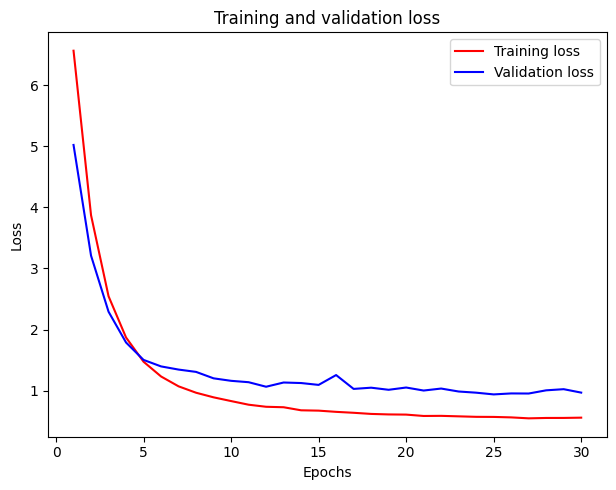

In [40]:
visualize_training_results(history.history)

In [41]:
prepare_test_dataset = AnnotationProcessor(annotation_file= str(TEST_DIR/'_annotations.csv'))
_class_map = {v: k for k, v in enumerate(CLASS_NAME)}
test_image_paths, test_class_ids, test_bboxes = prepare_test_dataset.process_annotations(image_dir=TEST_DIR, class_id_map=_class_map)

len(test_image_paths), len(test_class_ids), len(test_bboxes)

(973, 973, 973)

In [42]:
test_dl = DataLoader(test_image_paths, test_class_ids, test_bboxes, img_size=IMG_SIZE)
test_ds = test_dl.load_val_dataset()
y_true_labels = test_dl.multi_hot_class_ids
y_true_bboxes = test_dl.padded_bbx
test_ds = Preprocessor(test_ds).preprocess()
test_ds = test_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

In [43]:
results = model.evaluate(test_ds, return_dict=True, steps=1)
print("Testing accuracy: ", results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - bounding_box_iou_metric: 0.4902 - bounding_box_loss: 0.5098 - bounding_box_mae: 0.2055 - bounding_box_mse: 0.1132 - classification_AUC: 0.5925 - classification_f1_score: 0.6152 - classification_loss: 0.7142 - loss: 1.2722
Testing accuracy:  {'bounding_box_iou_metric': 0.4901822507381439, 'bounding_box_loss': 0.5098177194595337, 'bounding_box_mae': 0.20545804500579834, 'bounding_box_mse': 0.11316923797130585, 'classification_AUC': 0.5925325751304626, 'classification_f1_score': 0.6151719689369202, 'classification_loss': 0.7142318487167358, 'loss': 1.2722156047821045}


In [44]:
results

{'bounding_box_iou_metric': 0.4901822507381439,
 'bounding_box_loss': 0.5098177194595337,
 'bounding_box_mae': 0.20545804500579834,
 'bounding_box_mse': 0.11316923797130585,
 'classification_AUC': 0.5925325751304626,
 'classification_f1_score': 0.6151719689369202,
 'classification_loss': 0.7142318487167358,
 'loss': 1.2722156047821045}

In [45]:
from sklearn.metrics import classification_report

y_prob_pred, pred_bbx = model.predict(test_ds)
y_prob_pred[0], pred_bbx[0]

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step


(array([0.9974049 , 0.9424087 , 0.99841857], dtype=float32),
 array([[0.58337295, 0.65298855, 0.7798763 , 0.86219513],
        [0.39970443, 0.60062015, 0.8951821 , 0.95044905],
        [0.58484167, 0.6523432 , 0.79652023, 0.8798728 ]], dtype=float32))

In [46]:
y_pred = (y_prob_pred>0.5).astype(int)
y_pred

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

In [47]:
report = classification_report(y_true_labels, y_pred, labels=[0,1,2], target_names=CLASS_NAME)
print(report)

              precision    recall  f1-score   support

      label0       0.94      0.86      0.90       588
      label1       0.99      0.99      0.99       962
      label2       0.94      0.86      0.90       554

   micro avg       0.96      0.92      0.94      2104
   macro avg       0.96      0.91      0.93      2104
weighted avg       0.96      0.92      0.94      2104
 samples avg       0.97      0.93      0.93      2104



/code/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


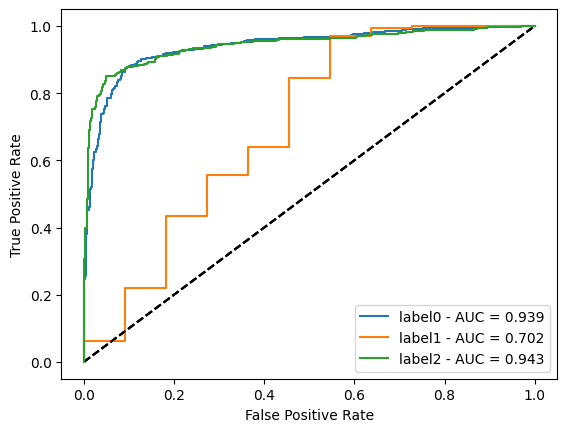

In [49]:
from src.utils.visualization_funcs import plot_auc_curve


plot_auc_curve(cfg, CLASS_NAME, y_true_labels, y_prob_pred)

In [50]:
test_bboxes

[array([[0.61151079, 0.65909091, 0.75539568, 0.82575758],
        [0.36690647, 0.58333333, 0.85611511, 0.98484848],
        [0.58992806, 0.66666667, 0.78417266, 0.84090909]]),
 array([[0.61151079, 0.09848485, 0.99280576, 0.4469697 ]]),
 array([[0.23021583, 0.53787879, 0.70503597, 0.97727273],
        [0.1942446 , 0.41666667, 0.97841727, 0.97727273],
        [0.28057554, 0.58333333, 0.55395683, 0.86363636]]),
 array([[0.54676259, 0.04545455, 0.84892086, 0.39393939],
        [0.65467626, 0.24242424, 0.89928058, 0.35606061],
        [0.55395683, 0.0530303 , 0.85611511, 0.39393939]]),
 array([[0.20863309, 0.64393939, 0.60431655, 0.84848485],
        [0.22302158, 0.68181818, 0.26618705, 0.74242424]]),
 array([[0.24460432, 0.52272727, 0.88489209, 0.93939394],
        [0.13669065, 0.46212121, 1.        , 0.99242424],
        [0.25899281, 0.52272727, 0.88489209, 0.90909091]]),
 array([[0.61870504, 0.41666667, 0.63309353, 0.43181818]]),
 array([[0.39568345, 0.5       , 0.71942446, 0.70454545]])

In [51]:
pred_bbx

array([[[0.58337295, 0.65298855, 0.7798763 , 0.86219513],
        [0.39970443, 0.60062015, 0.8951821 , 0.95044905],
        [0.58484167, 0.6523432 , 0.79652023, 0.8798728 ]],

       [[0.67533726, 0.14109503, 0.9578135 , 0.43031222],
        [0.6291663 , 0.10937945, 0.97219914, 0.46345052],
        [0.66635334, 0.14659081, 0.94753504, 0.45024416]],

       [[0.29983747, 0.5741464 , 0.7062712 , 0.89462227],
        [0.23650244, 0.51755124, 0.8501267 , 0.9519433 ],
        [0.34405422, 0.5844759 , 0.7171226 , 0.8840931 ]],

       ...,

       [[0.0058202 , 0.1031983 , 0.34023654, 0.5837982 ],
        [0.00175997, 0.07904447, 0.4788545 , 0.5827698 ],
        [0.00956631, 0.10122242, 0.3136276 , 0.53147674]],

       [[0.02099554, 0.14537515, 0.2842593 , 0.42160106],
        [0.00414458, 0.04785204, 0.68055975, 0.57663584],
        [0.02279886, 0.1273388 , 0.30086887, 0.41263857]],

       [[0.37009698, 0.5282765 , 0.60874736, 0.71965426],
        [0.24741058, 0.50034416, 0.71267927, 0.79

In [56]:
from src.losses.iou_loss import iou_metric
def plot_iou_histogram(y_true_bbox, y_pred_bbox, class_ids):
    """
    Plots a histogram of Intersection over Union (IoU) scores.

    Args:
        y_true_bbox: Ground truth bounding boxes (list of lists or numpy array).
        y_pred_bbox: Predicted bounding boxes (list of lists or numpy array).
        class_ids: list of class ids.
    """
    fig, axs = plt.subplots(1)

    iou_scores = iou_metric(y_true_bbox, y_pred_bbox)

    # fig.figure(figsize=(10, 6))
    axs.hist(iou_scores, bins=20, range=(0, 1), edgecolor='black')
    axs.set_title('IoU Score Distribution')
    axs.set_xlabel('IoU Score')
    axs.set_ylabel('Frequency')
    axs.grid(True)
    plt.show()
    plt.savefig(f"{cfg.OUTPUTS.OUPUT_DIR}/iou_histogram.png")
    return fig


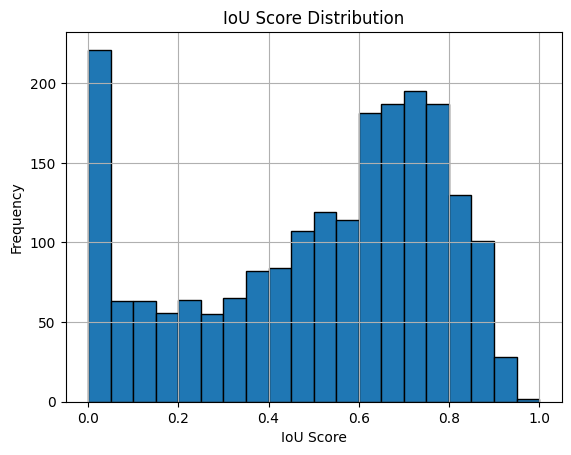

<Figure size 640x480 with 0 Axes>

In [57]:
fig = plot_iou_histogram(y_true_bboxes, pred_bbx, pred_bbx)
mlflow.log_figure(fig, 'iou_histogram.png')